<div style="text-align: center; font-size: 20px;"><b>Stats216v: Statistical Learning</b></div>

<br>
<div style="text-align: center">Stanford University</div>
<div style="text-align: center">Summer 2017</div>
<div style="text-align: center">Gyu-Ho Lee (<a href="mailto:gyuhox@gmail.com">gyuhox@gmail.com</a>)</div>

#### 8. Tree-Based Methods

In [1]:
LoadLibraries = function() {
    library(MASS)
    install.packages("ISLR")
    library(ISLR)
    print("Libraries have been loaded!")
}

LoadLibraries()

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


[1] "Libraries have been loaded!"


In [42]:
names(Boston)

[1] "crim"    "zn"      "indus"   "chas"    "nox"     "rm"      "age"    
 [8] "dis"     "rad"     "tax"     "ptratio" "black"   "lstat"   "medv"

In [43]:
# lm(y~x,data)
# y: response, x: predictor
lm.fit = lm(medv~lstat, data=Boston)
summary(lm.fit)


Call:
lm(formula = medv ~ lstat, data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.168  -3.990  -1.318   2.034  24.500 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 34.55384    0.56263   61.41   <2e-16 ***
lstat       -0.95005    0.03873  -24.53   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.216 on 504 degrees of freedom
Multiple R-squared:  0.5441,	Adjusted R-squared:  0.5432 
F-statistic: 601.6 on 1 and 504 DF,  p-value: < 2.2e-16


In [44]:
names(lm.fit)
coef(lm.fit)
confint(lm.fit)

[1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"

(Intercept)       lstat 
 34.5538409  -0.9500494

,2.5 %,97.5 %
(Intercept),33.448457,35.6592247
lstat,-1.026148,-0.8739505


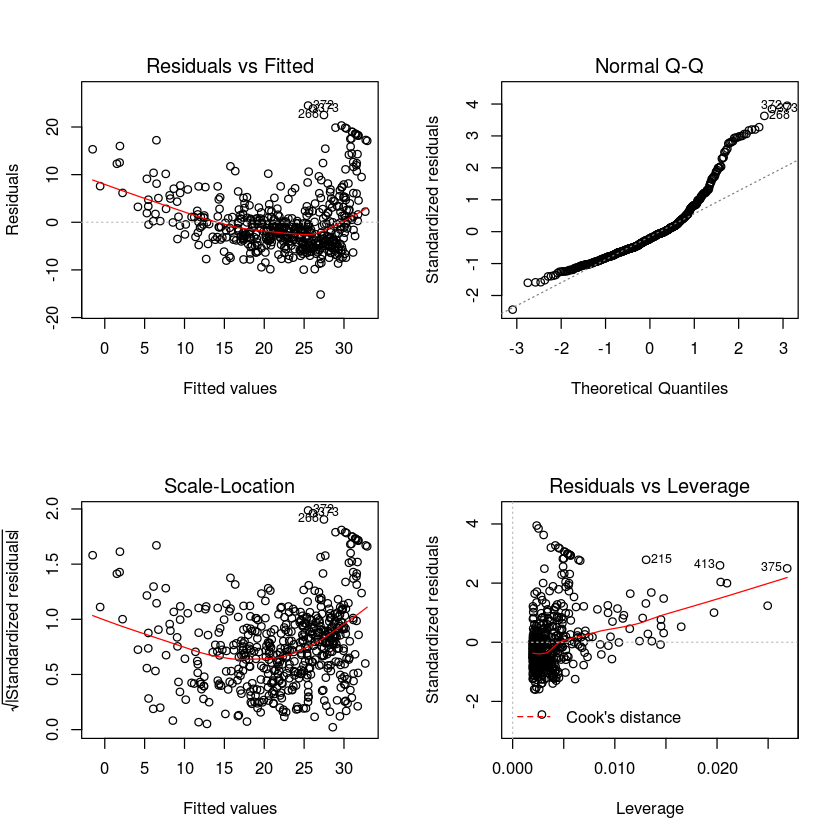

In [45]:
par(mfrow=c(2,2))
plot(lm.fit)
# plot(lm.fit$residuals, lm.fit$fitted)

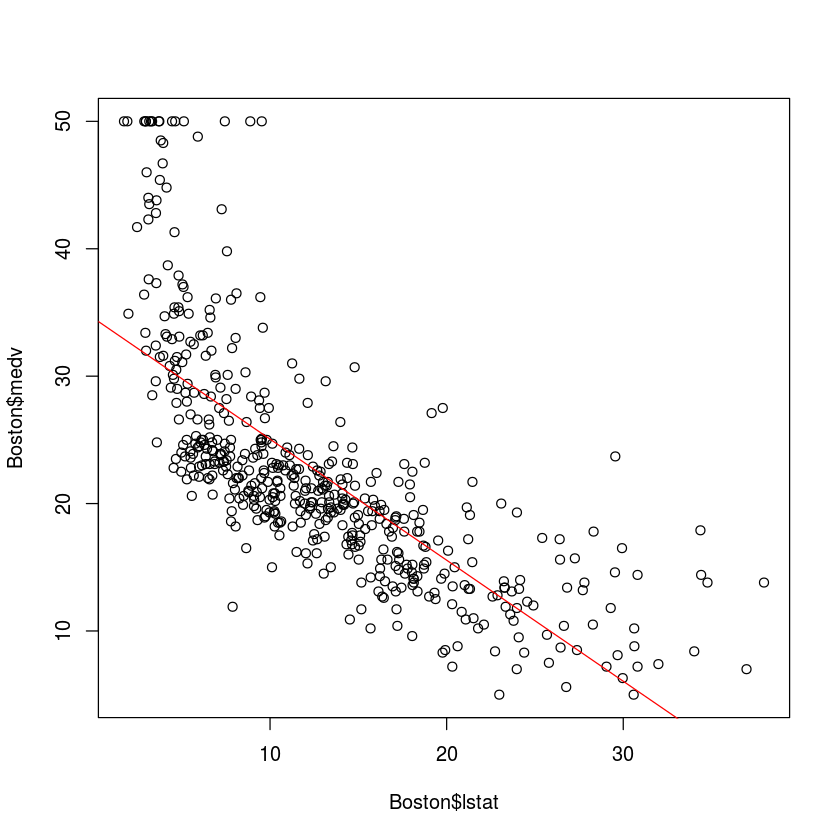

In [46]:
plot(Boston$lstat, Boston$medv)
abline(lm.fit, col="red")

In [47]:
# multiple linear regression
summary(lm(medv~lstat+age, data=Boston))


Call:
lm(formula = medv ~ lstat + age, data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.981  -3.978  -1.283   1.968  23.158 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 33.22276    0.73085  45.458  < 2e-16 ***
lstat       -1.03207    0.04819 -21.416  < 2e-16 ***
age          0.03454    0.01223   2.826  0.00491 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.173 on 503 degrees of freedom
Multiple R-squared:  0.5513,	Adjusted R-squared:  0.5495 
F-statistic:   309 on 2 and 503 DF,  p-value: < 2.2e-16


In [48]:
summary(lm(medv~., data=Boston))


Call:
lm(formula = medv ~ ., data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.595  -2.730  -0.518   1.777  26.199 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.646e+01  5.103e+00   7.144 3.28e-12 ***
crim        -1.080e-01  3.286e-02  -3.287 0.001087 ** 
zn           4.642e-02  1.373e-02   3.382 0.000778 ***
indus        2.056e-02  6.150e-02   0.334 0.738288    
chas         2.687e+00  8.616e-01   3.118 0.001925 ** 
nox         -1.777e+01  3.820e+00  -4.651 4.25e-06 ***
rm           3.810e+00  4.179e-01   9.116  < 2e-16 ***
age          6.922e-04  1.321e-02   0.052 0.958229    
dis         -1.476e+00  1.995e-01  -7.398 6.01e-13 ***
rad          3.060e-01  6.635e-02   4.613 5.07e-06 ***
tax         -1.233e-02  3.760e-03  -3.280 0.001112 ** 
ptratio     -9.527e-01  1.308e-01  -7.283 1.31e-12 ***
black        9.312e-03  2.686e-03   3.467 0.000573 ***
lstat       -5.248e-01  5.072e-02 -10.347  < 2e-16 ***
---
Signif. codes:  0

In [49]:
# interaction terms
summary(lm(medv~lstat*age, data=Boston))


Call:
lm(formula = medv ~ lstat * age, data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.806  -4.045  -1.333   2.085  27.552 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 36.0885359  1.4698355  24.553  < 2e-16 ***
lstat       -1.3921168  0.1674555  -8.313 8.78e-16 ***
age         -0.0007209  0.0198792  -0.036   0.9711    
lstat:age    0.0041560  0.0018518   2.244   0.0252 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.149 on 502 degrees of freedom
Multiple R-squared:  0.5557,	Adjusted R-squared:  0.5531 
F-statistic: 209.3 on 3 and 502 DF,  p-value: < 2.2e-16


In [50]:
# non-linear transformation
summary(lm(medv~lstat+poly(lstat,2), data=Boston))


Call:
lm(formula = medv ~ lstat + poly(lstat, 2), data = Boston)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2834  -3.8313  -0.5295   2.3095  25.4148 

Coefficients: (1 not defined because of singularities)
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     34.55384    0.49999   69.11   <2e-16 ***
lstat           -0.95005    0.03442  -27.60   <2e-16 ***
poly(lstat, 2)1       NA         NA      NA       NA    
poly(lstat, 2)2 64.22724    5.52371   11.63   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.524 on 503 degrees of freedom
Multiple R-squared:  0.6407,	Adjusted R-squared:  0.6393 
F-statistic: 448.5 on 2 and 503 DF,  p-value: < 2.2e-16


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
504,19472.38,NA,NA,NA,NA
503,15347.24,1,4125.138,135.1998,7.630116e-28


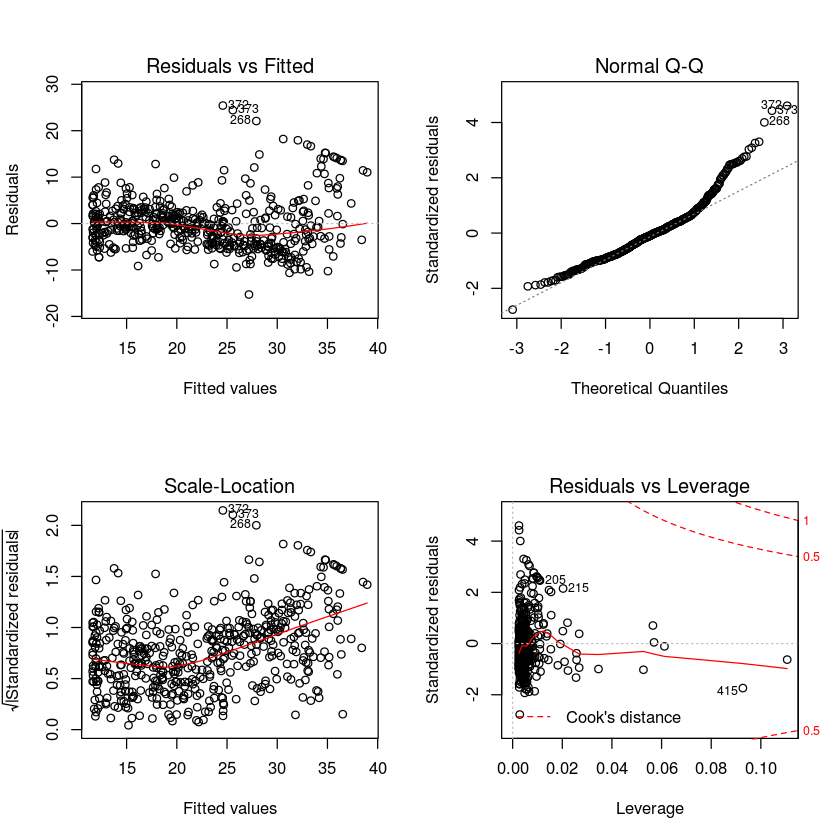

In [51]:
lm.fit1 = lm(medv~lstat, data=Boston)
lm.fit2 = lm(medv~lstat+poly(lstat,2), data=Boston)
anova(lm.fit1, lm.fit2)

par(mfrow=c(2,2))
plot(lm.fit2)

In [52]:
head(Carseats)
lm.fit = lm(Sales~.+Income:Advertising+Price:Age, data=Carseats)
summary(lm.fit)

Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
11.22,111,48,16,260,83,Good,65,10,Yes,Yes
10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4.15,141,64,3,340,128,Bad,38,13,Yes,No
10.81,124,113,13,501,72,Bad,78,16,No,Yes



Call:
lm(formula = Sales ~ . + Income:Advertising + Price:Age, data = Carseats)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9208 -0.7503  0.0177  0.6754  3.3413 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         6.5755654  1.0087470   6.519 2.22e-10 ***
CompPrice           0.0929371  0.0041183  22.567  < 2e-16 ***
Income              0.0108940  0.0026044   4.183 3.57e-05 ***
Advertising         0.0702462  0.0226091   3.107 0.002030 ** 
Population          0.0001592  0.0003679   0.433 0.665330    
Price              -0.1008064  0.0074399 -13.549  < 2e-16 ***
ShelveLocGood       4.8486762  0.1528378  31.724  < 2e-16 ***
ShelveLocMedium     1.9532620  0.1257682  15.531  < 2e-16 ***
Age                -0.0579466  0.0159506  -3.633 0.000318 ***
Education          -0.0208525  0.0196131  -1.063 0.288361    
UrbanYes            0.1401597  0.1124019   1.247 0.213171    
USYes              -0.1575571  0.1489234  -1.058 0.290729    
Inco

In [53]:
contrasts(Carseats$ShelveLoc)

,Good,Medium
Bad,0,0
Good,1,0
Medium,0,1
